# Optimization of TensorFlow models with TF-Lite and TensorRT

In this notebook you will learn how to use the TensorFlow integration for TF-Lite and TensorRT (also known as TF-TRT) to increase inference performance.

## Objectives

By the time you complete this workshop you will be able to:

- Optimize several deep learning models with TF-TRT
- Describe how TF-TRT optimizes models
- Use TF-TRT to optimize models at FP32 precision
- Use TF-TRT to optimize models at FP16 precision
- Perform calibration for INT8 precision optimization
- Perform experiments to understand the impact of conversion parameters on optimization

In [0]:
from IPython.display import Image

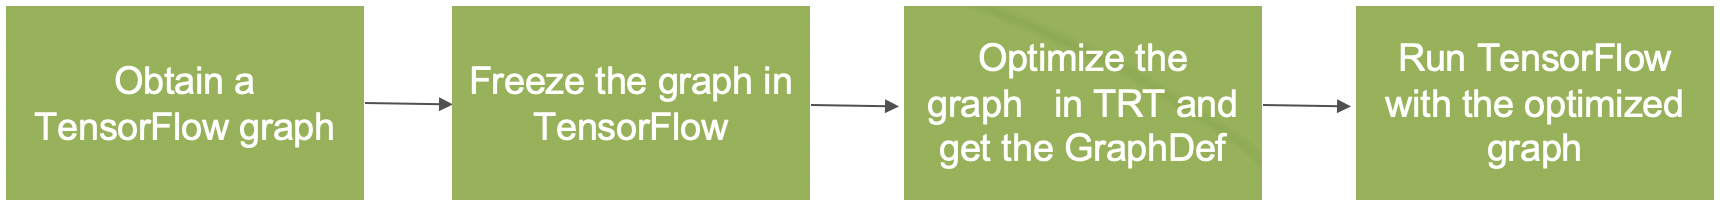

In [16]:
Image("images/pipeline.png")

## Prerequisites

In order to be successful with this notebook, it is assumed you:

- Are competent in the Python programming language
- Are familiar with Deep Learning, and understand what **inference** is
- Are familiar with TensorFlow, and its Keras API

## Contents

This workshop consists of several JupyterLab Notebooks.

- **A quick overview of how to work with thi Colaboratory environment**
- **Review inference with TF 2 and get familiar with helper functions used in this workshop**
- **Learn how TF-TRT optimizes models for faster inference**
- **Learn the syntax for performing optimization with TF-TRT**
- **Perform FP16 precision optimization** 
- **Learn how TF-TRT optimizes with INT8 precision** 
- **Perform data calibration and optimize with INT8 precision** 
- **Experiment with the impact of the minimum segment size conversion parameter, and optimize additional models** 

# Your Interactive Coding Environment

Before you begin programming, we would like to familiarize you with your interactive coding environment. This workshop utilizes the web-based coding interface [JupyterLab](https://jupyterlab.readthedocs.io/en/stable/) to execute code on a virtual machine backed by a [NVIDIA V100](https://www.nvidia.com/en-us/data-center/tesla-v100/) GPU accelerator. All necessary libraries have already been installed for you.

## Available GPU Accelerators

We can use these interactive cells to run shell commands by prefixing them with `!`. For example, execute the following cell to run the shell command `nvidia-smi`, which will print information about your environment's available GPUs, their current memory usage, and any processes currently utilizing them:

### Watching `nvidia-smi`

Use the Jupyter *File* menu and run *New Laucher*. When prompted, select a new terminal. Once this terminal opens, issue the command `watch -n 1 nvidia-smi`. This will call and present the output of `nvidia-smi` every second, and provide you with a handy way to check in on memory usage throughout the workshop.

In [0]:
!nvidia-smi

Fri Apr 10 21:05:57 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 445.75       Driver Version: 445.75       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1050   WDDM  | 00000000:02:00.0 Off |                  N/A |
| N/A   35C    P8     8W /  N/A |    373MiB /  2048MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

As you can see almost no GPU memory is being used right now, and, there are no active processes utilizing the GPUs. Throughout the lab you can use this command to keep an eye on memory usage.

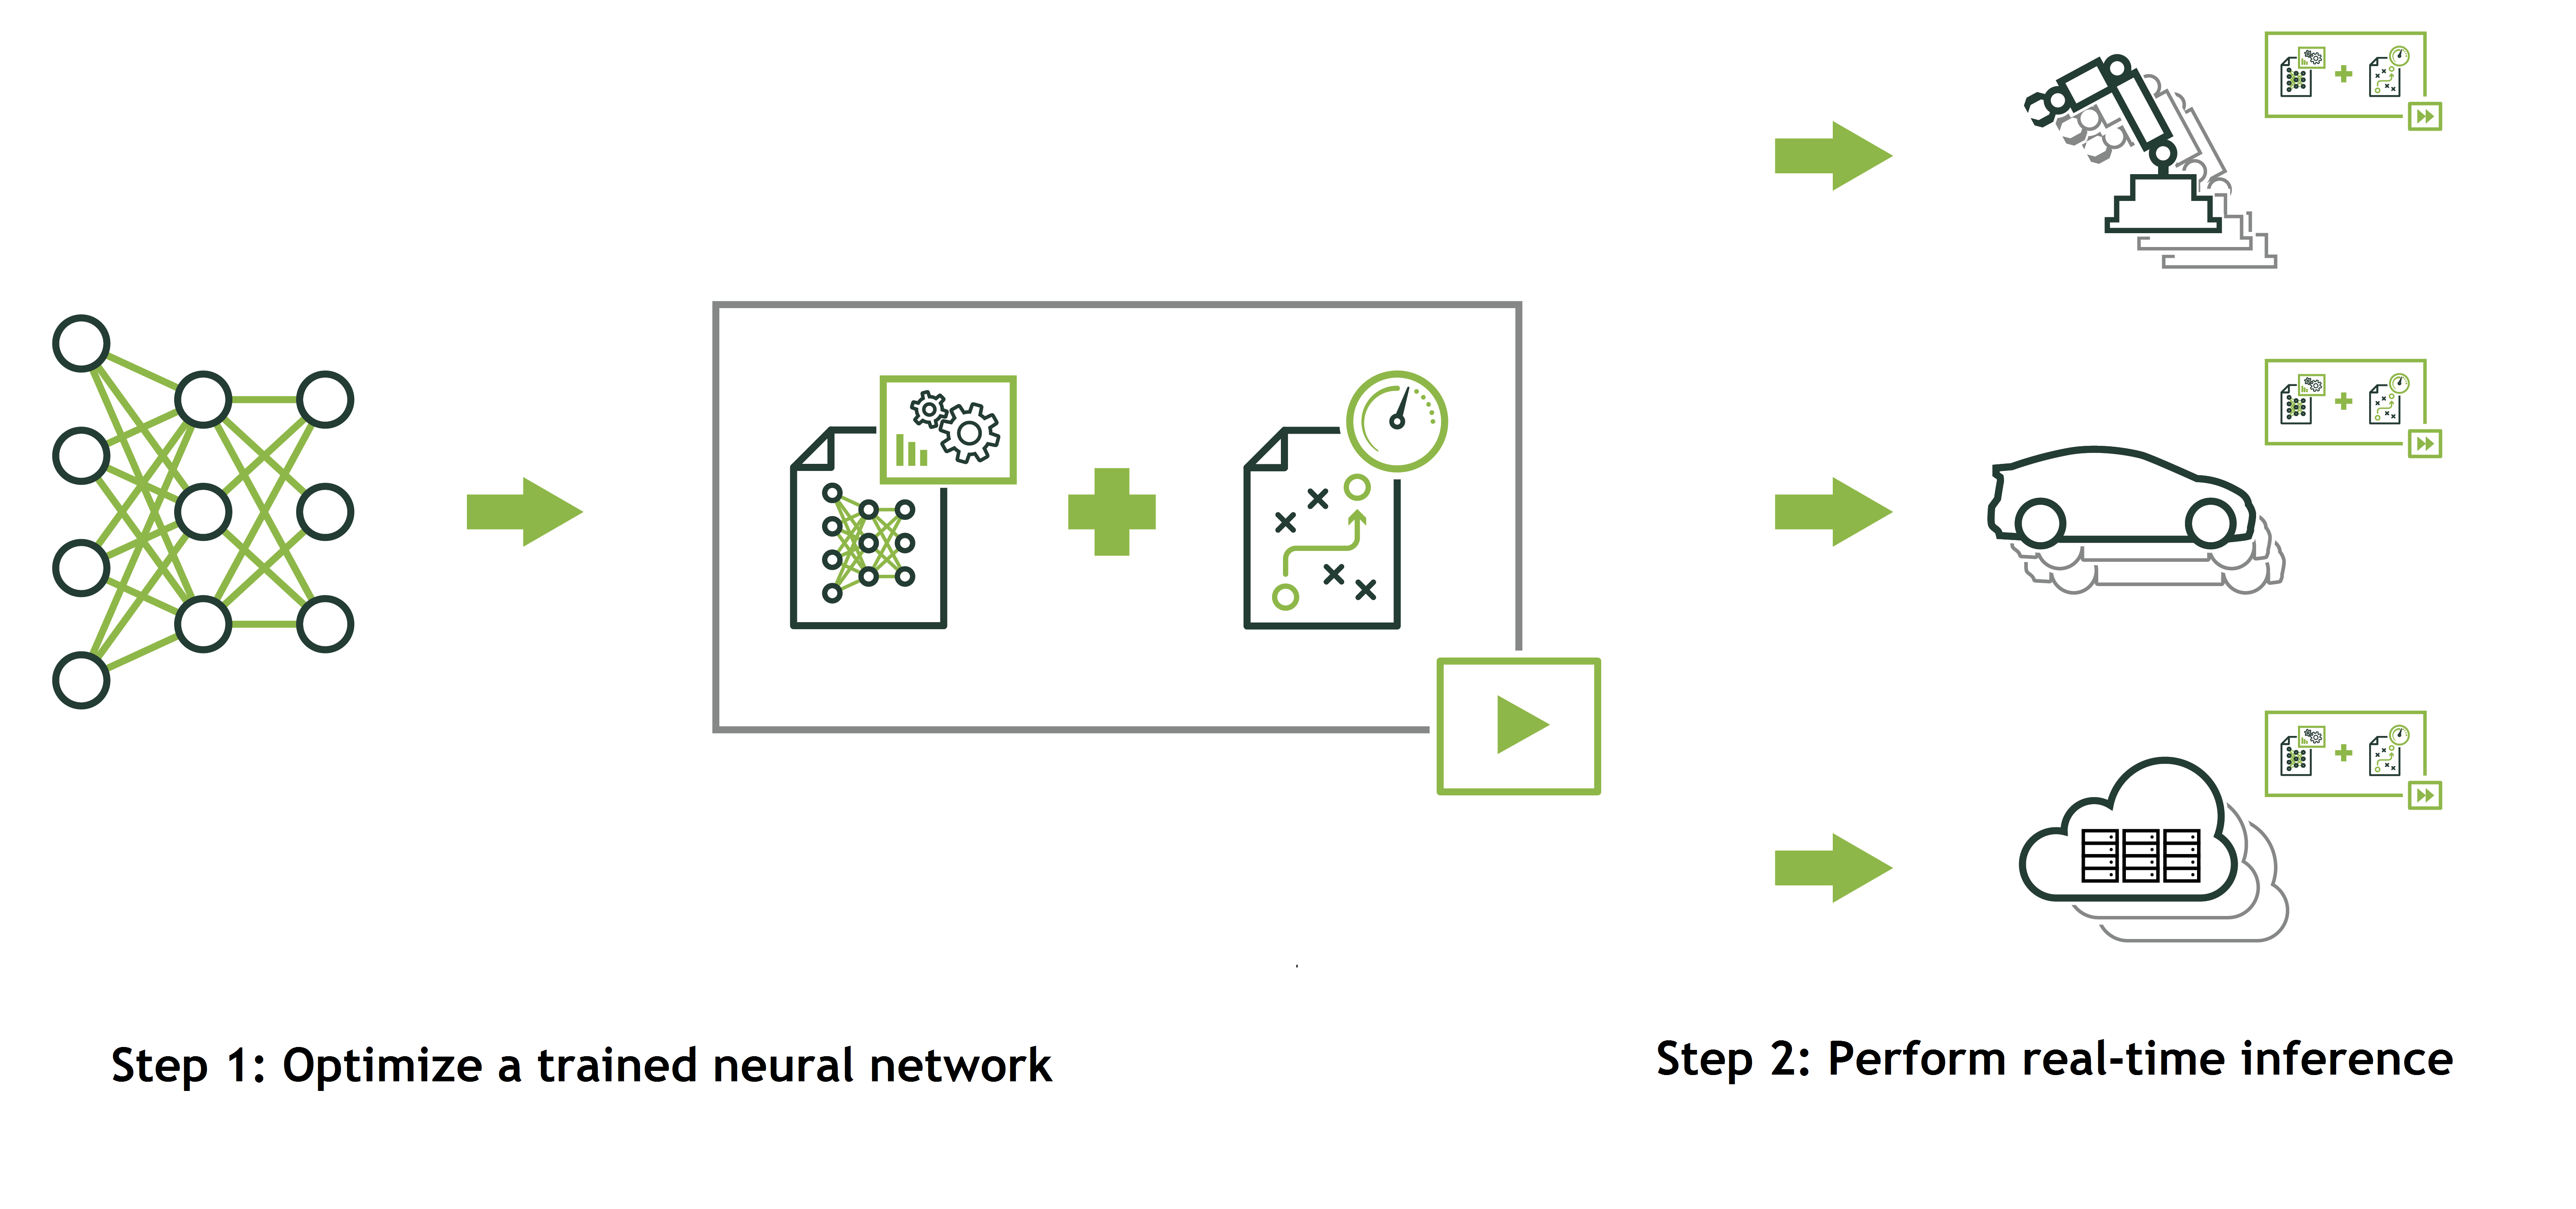

In [17]:
Image("images/GIE_Graphics_FINAL-1.png")

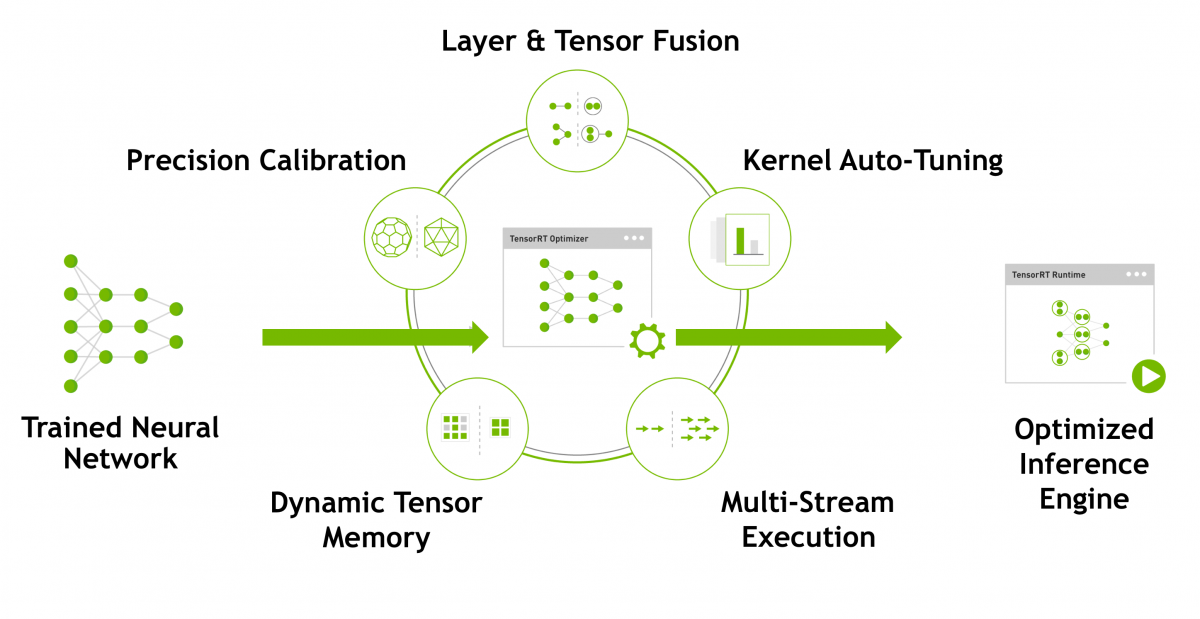

In [18]:
Image("images/trt-info.png")

# Naive Inference with TensorFlow 2

In this notebook we will run inference with TensorFlow 2, without the help of TF-TRT. In doing so we will establish baselines for image throughput and prediction accuracy which we can use as we optimze with TF-TRT.

Additionally, we will spend some time getting familiar with several helper functions we will use throughout this workshop that will allow us to perform common tasks easily so we can focus on the impact of using TF-TRT.

## Objectives

By the time you complete this notebook you should be able to:

- Use provided helper functions to load images, batch input, make and benchmark predictions, and display prediction information
- Obtain a baseline for naive TensorFlow 2 inference

## Imports

In [0]:
import tensorflow as tf
from tensorflow.python.saved_model import tag_constants

Throughout the workshop we will make extensive use of helper functions defined in `./lab_helpers.py`. Comments will be provided throughout to give context to their use, but at any time, feel free to use the JupyterLab file viewer on the left-hand side of the screen to open `lab_helpers.py` and view the helper functions in thier entirety.

In [0]:
from lab_helpers import (
    get_images, batch_input, predict_and_benchmark_throughput_from_saved, display_prediction_info
)

## Load and Save Model

Thoughout much of this workshop we will be using ResNetV2. Here we import the model from Keras.

In [0]:
from tensorflow.keras.applications.resnet_v2 import ResNet152V2

In [0]:
model = ResNet152V2(weights='imagenet')

When we benchmark our optimized TF-TRT models, they will be saved TensorFlow (not Keras) models. In order to have a fair comparison, here we save our Keras model as a TensorFlow model.

In [0]:
tf.saved_model.save(model, 'resnet_v2_152_saved_model')

## Create Batched Input

Using **batch inference** to send many images to the GPU at once promotes parallel processing and improve throughput.

### Get Images

The `get_images` helper function will use Keras to load the number of images specified, returning for each image the image itself in PIL format, and its file path, which we will need later to load and view the images from within these notebooks.

In [0]:
number_of_images = 32
images = get_images(number_of_images)

In [0]:
images[:1]

### Batch Input

The `batch_input` helper function takes a list of images with their paths, as returned by `get_images`, and returns a tensor with the the images preprocessed.

In [0]:
batched_input = batch_input(images)

In [0]:
type(batched_input)

In [0]:
batched_input.shape

## Get Baseline for Prediction Throughput and Accuracy

The following will serve as a baseline for prediction throughput and accuracy.

## Load Model

Here we load a previously-saved ResnetV2 model.

In [0]:
def load_tf_saved_model(input_saved_model_dir):

    print('Loading saved model {}...'.format(input_saved_model_dir))
    saved_model_loaded = tf.saved_model.load(input_saved_model_dir, tags=[tag_constants.SERVING])
    return saved_model_loaded

In [0]:
saved_model_loaded = load_tf_saved_model('resnet_v2_152_saved_model')

In [0]:
infer = saved_model_loaded.signatures['serving_default']

### Make Prediction and Get Throughput

Now we perform inference with the optimized graph, and after a warmup, time and calculate throughput.

The helper functoin `predict_and_benchmark_throughput_from_saved` will use the passed in model to perform predictions on the passed in batched input over a number of runs. It measures and reports throughput, as well as time for ranges of runs.

Because, due to GPU initialization operations, we do not want to profile against initial inference, we can set a number of warmup runs to perform prior to benchmarking.

`predict_and_benchmark_throughput_from_saved` returns the predictions for all images for all runs, after the warmup.

In [0]:
all_preds = predict_and_benchmark_throughput_from_saved(batched_input, infer, N_warmup_run=50, N_run=150)

**Make note of the *Throughput* value for this naive TensorFlow 2 inference.**

### Observe Accuracy

The helper function `display_prediction_info` will display the images along with their top predictions from a single run. You can **Right Click** on the image output and then choose **Enable Scrolling** to prevent the many displayed images from taking up the whole screen.

**NOTE:** We are not so concerned in this workshop about the accuracy of our predicions per se, only that they remain consistent as we optimize our models.

In [0]:
last_run_preds = all_preds[0]
display_prediction_info(last_run_preds, images, top=2)

## Next

In the next notebook you will learn how TF-TRT optimizes saved models.

# TF-TRT Inference

This notebook gives a high-level description of how TF-TRT optimizes graphs, and also, how to code this optimization. In the next notebook you will use this knowledge to code a TF-TRT optimization.

## Objectives

By the time you complete this notebook you will be able to:

- Describe how TF-TRT performs graph optimization
- Describe how to use `TrtGraphConverterV2` to code TF-TRT graph optimizations

## Network Transformation

TF-TRT performs several important transformations and optimizations to the neural network graph. First, layers with unused outputs are eliminated to avoid unnecessary computation. Next, where possible, convolution, bias, and ReLU layers are fused to form a single layer. *Figure 1* shows a typical convolutional network before optimization:

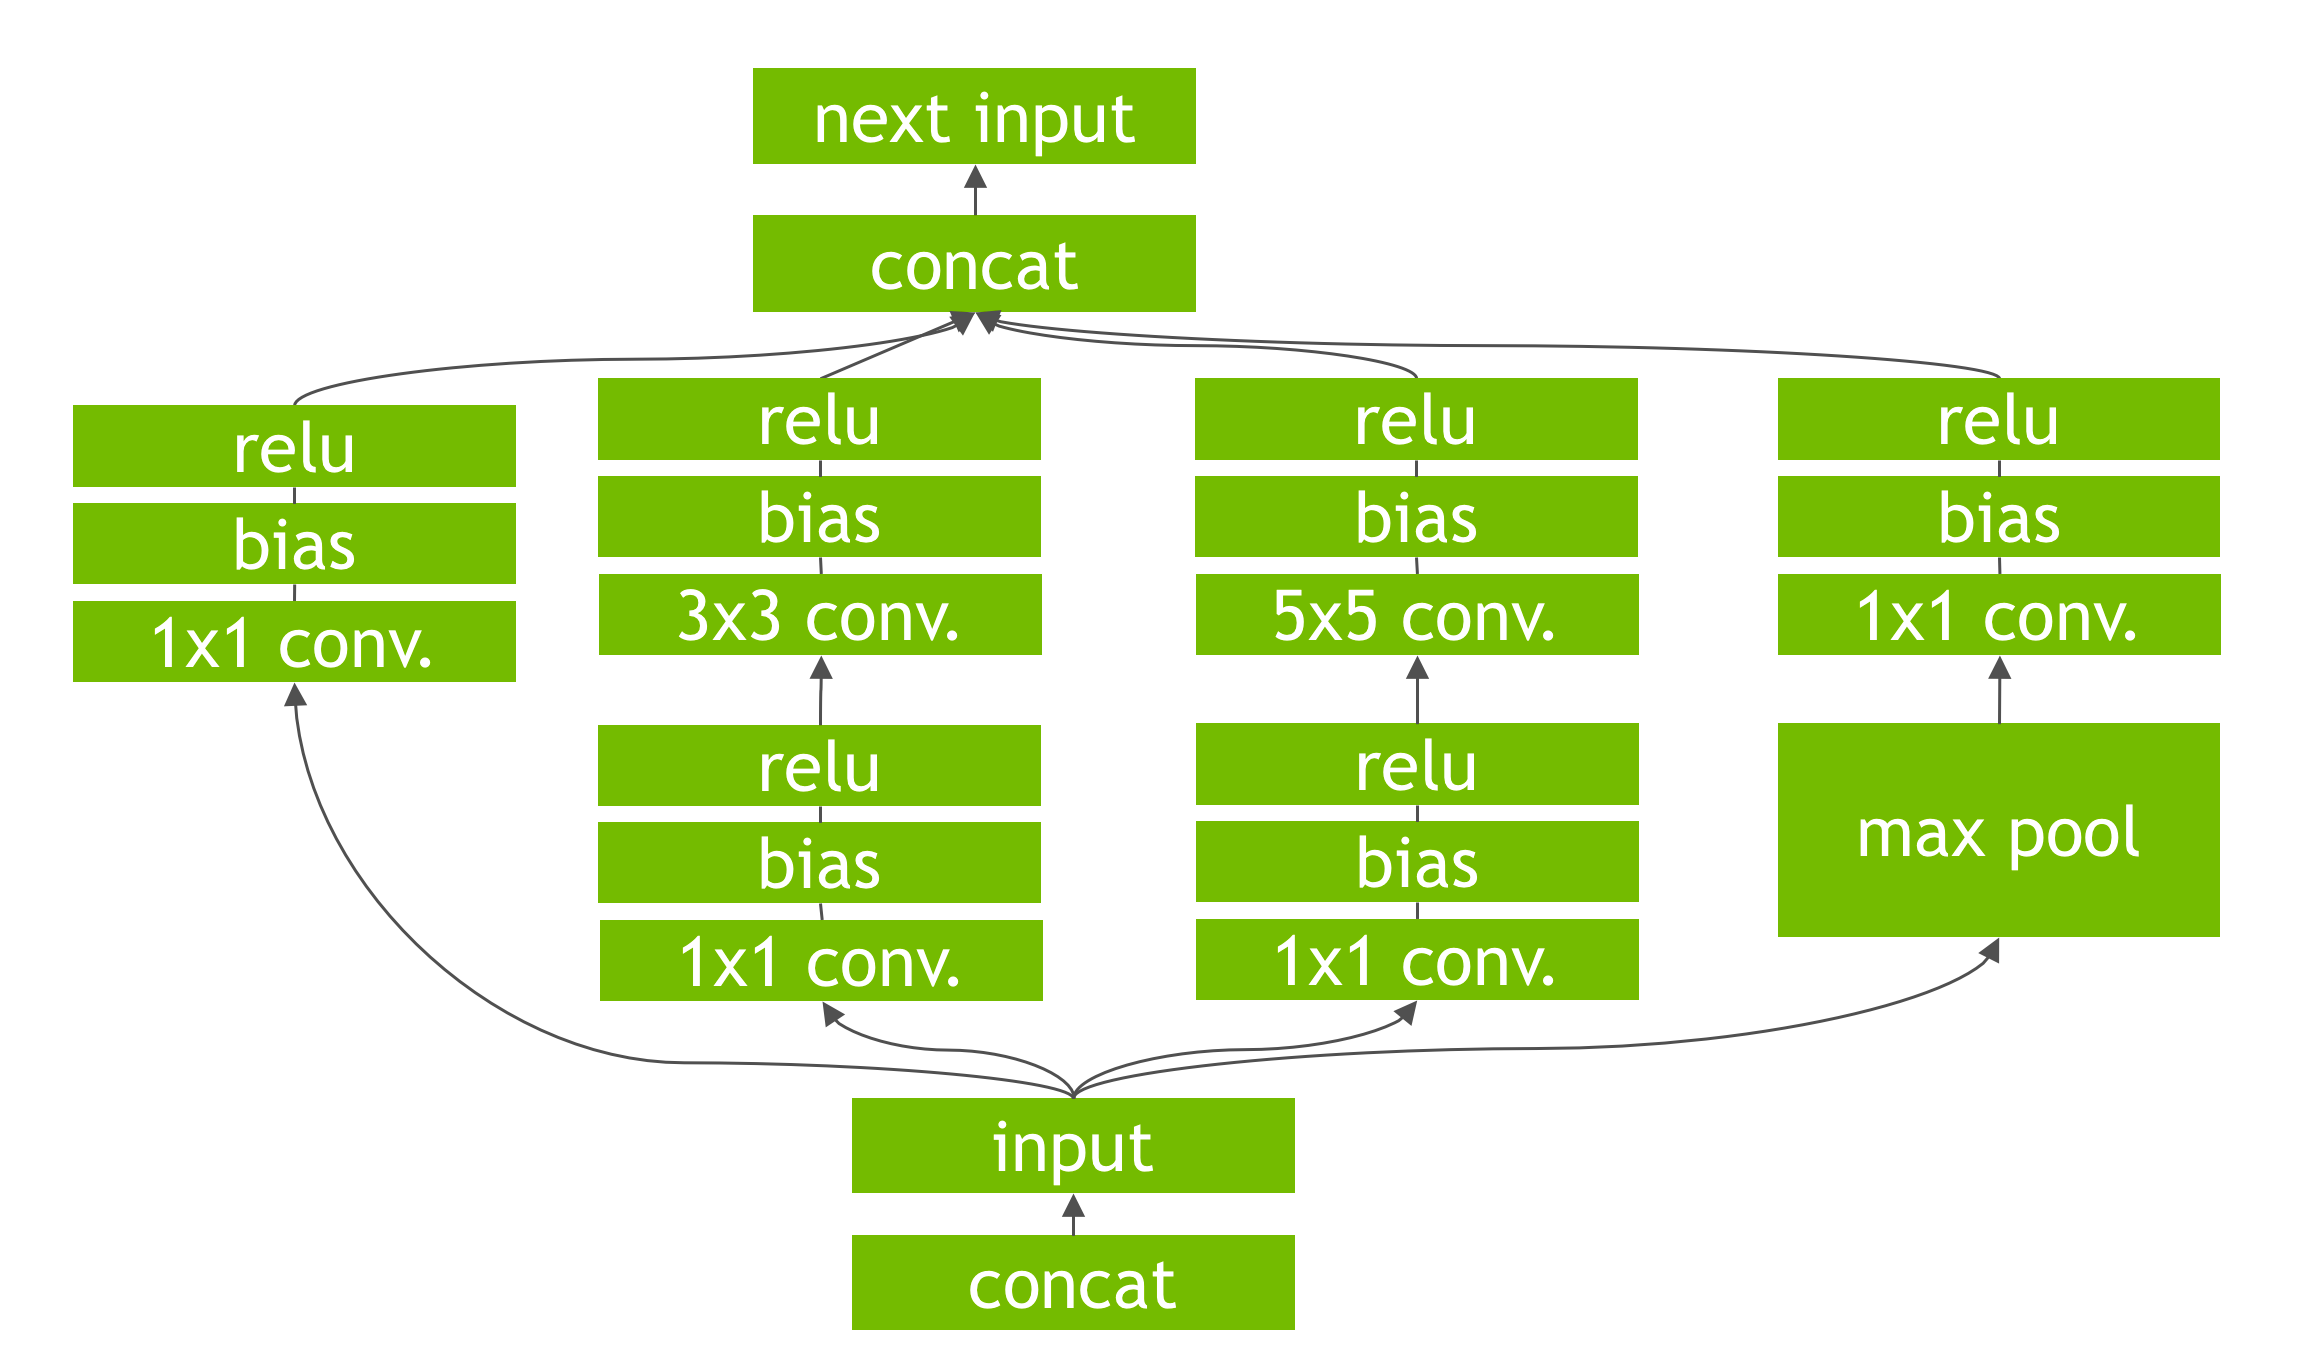

In [19]:
Image("images/network_optimization.png")

*Figure 2* shows the result of this vertical layer fusion on the original network from Figure 1 (fused layers are labeled CBR). Layer fusion improves the efficiency of running TF-TRT networks on the GPU.

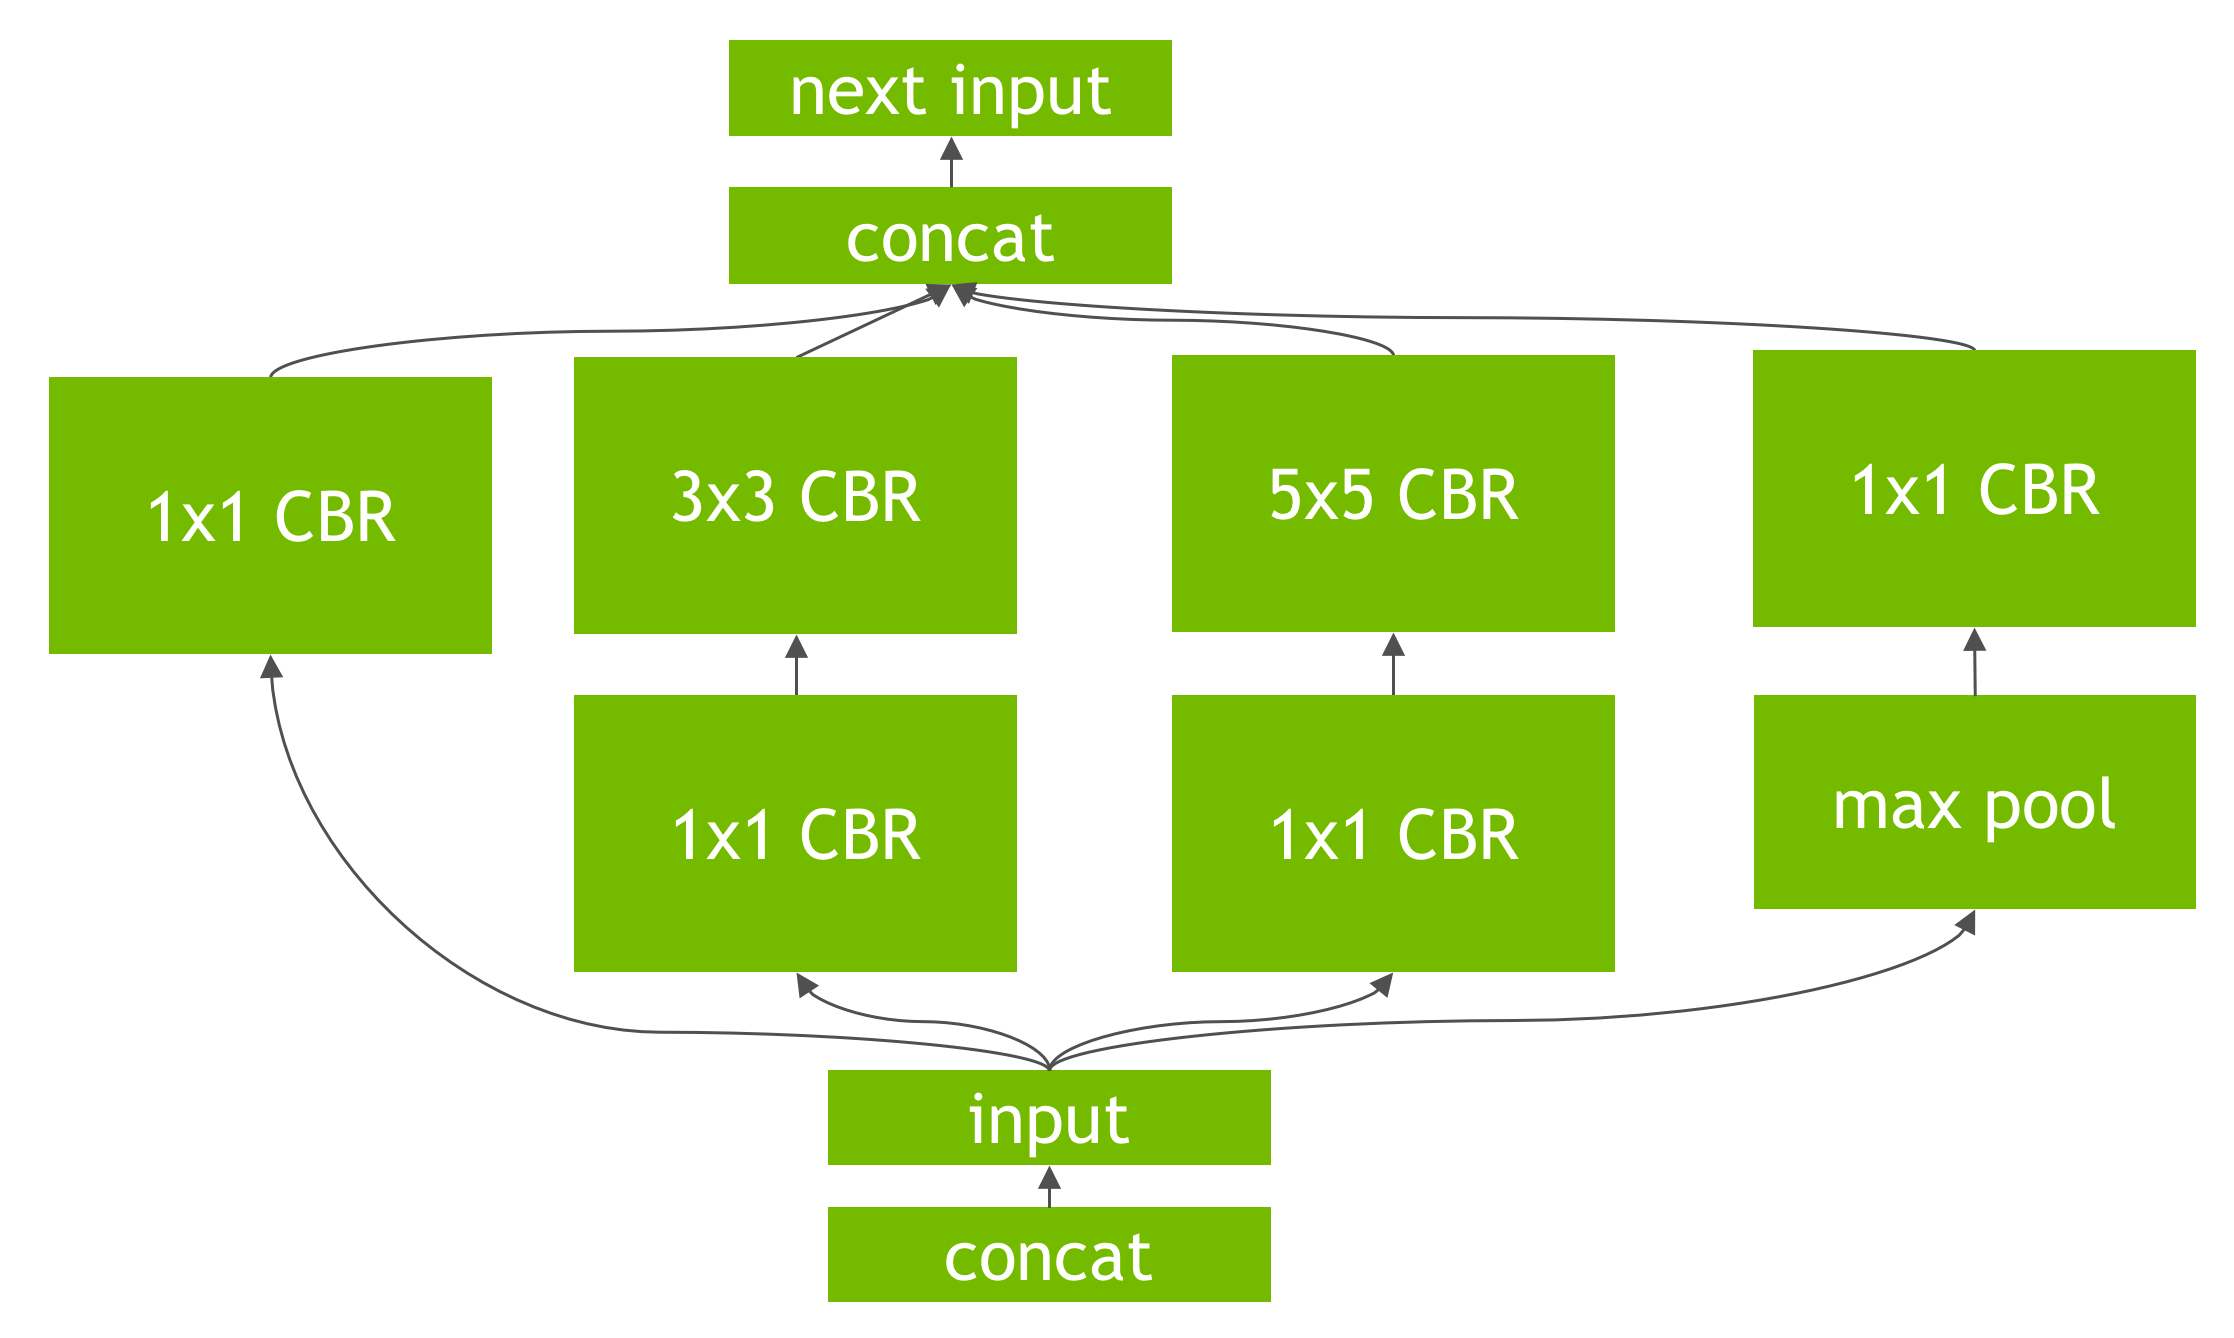

In [20]:
Image("images/network_vertical_fusion.png")

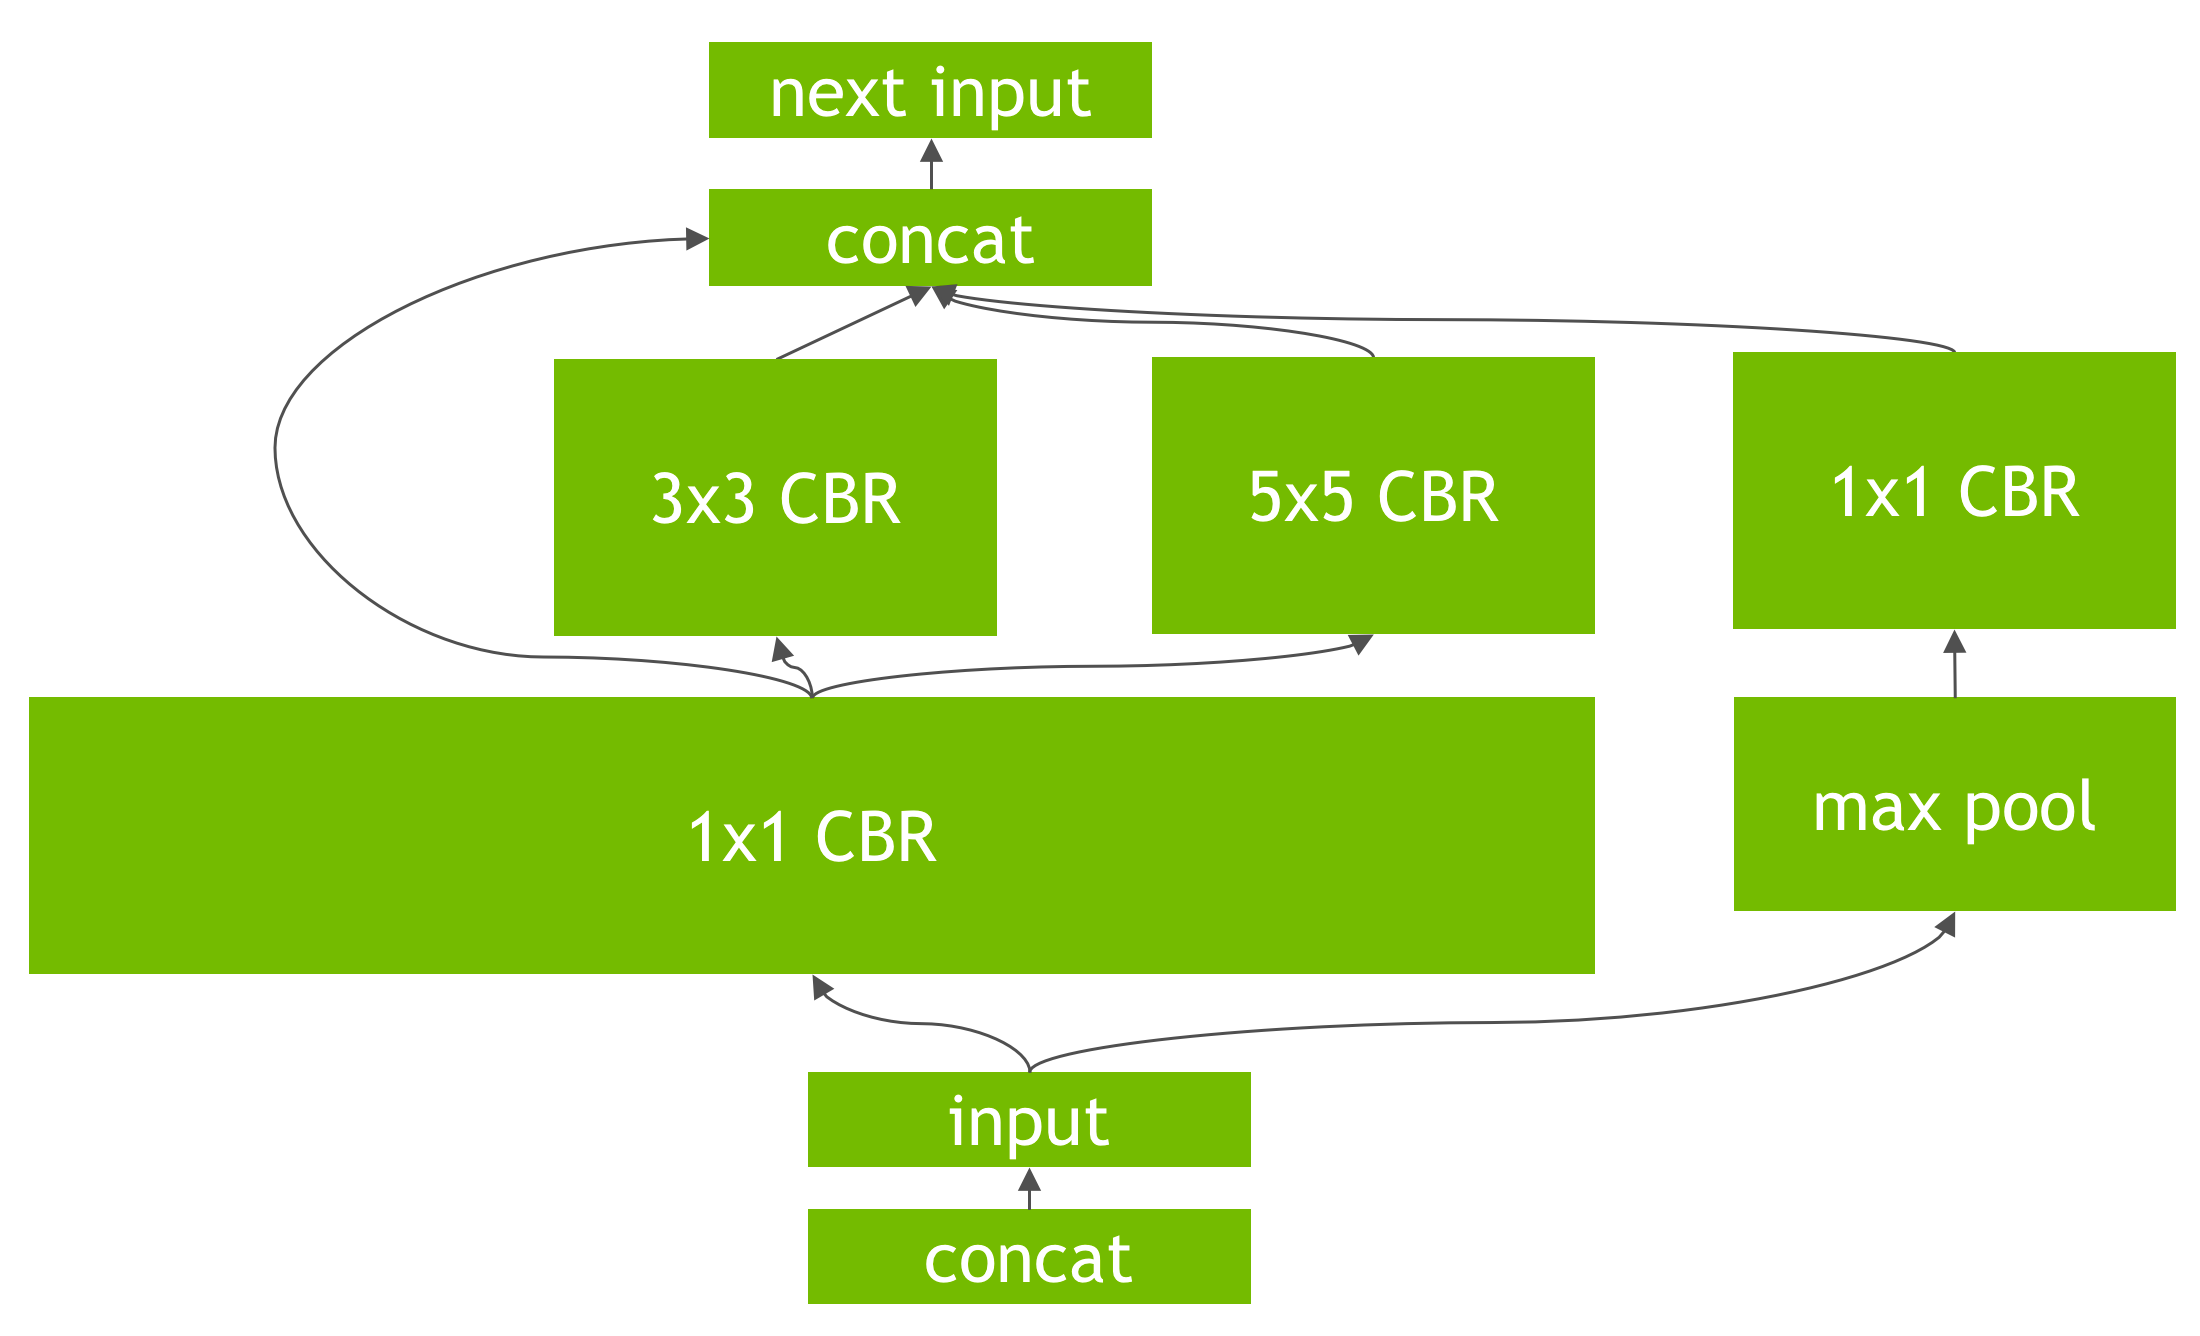

In [21]:
Image("images/network_horizontal_fusion.png")

When optimizing a TensorFlow model, TF-TRT can optimize either a subgraph or the entire graph definition. This capability allows the optimization procedure to be applied to the graph where possible and skip the non-supported graph segments. As a result, if the existing model contains a non-supported layer or operation, TensorFlow can still optimize the graph. 

Please see the [TF-TRT User Guide](https://docs.nvidia.com/deeplearning/frameworks/tf-trt-user-guide/index.html#supported-ops) for a full list of supported operators.

## TF-TRT Workflow

Below, you can see a typical workflow of TF-TRT:

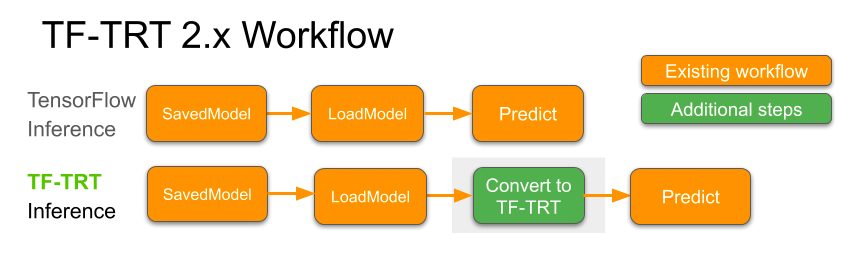

In [22]:
Image("images/inference_process_fp.png")

We now turn to the syntax for this one additional *Convert to TF-TRT* step.

## Graph Conversion

To perform graph conversion, we use `TrtGraphConverterV2`, passing it the directory of a saved model, and any updates we wish to make to its conversion parameters.

```python
from tensorflow.python.compiler.tensorrt import trt_convert as trt

trt.TrtGraphConverterV2(
    input_saved_model_dir=None,
    conversion_params=TrtConversionParams(precision_mode='FP32',
                                          max_batch_size=1
                                          minimum_segment_size=3,
                                          max_workspace_size_bytes=1073741824,
                                          use_calibration=True,
                                          maximum_cached_engines=1,
                                          is_dynamic_op=True,
                                          rewriter_config_template=None,
                                         )
```

### Conversion Parameters

Another transformation is horizontal layer fusion, or layer aggregation, along with the required division of aggregated layers to their respective outputs, as Figure 3 shows.

Horizontal layer fusion improves performance by combining layers that take the same source tensor and apply the same operations with similar parameters, resulting in a single larger layer for higher computational efficiency. The example in Figure 3 shows the combination of 3 1×1 CBR layers from Figure 2 that take the same input into a single larger 1×1 CBR layer. Note that the output of this layer must be disaggregated to feed into the different subsequent layers from the original input graph.

Here is additional information about the most frequently adjusted conversion parameters, all of which you will have an opportunity to code with in later exercises.

* __precision_mode__: This parameter sets the precision mode; which can be one of FP32, FP16, or INT8. Precision lower than FP32, meaning FP16 and INT8, would improve the performance of inference. The FP16 mode uses Tensor Cores or half precision hardware instructions, if possible. The INT8 precision mode uses integer hardware instructions.

* __max_batch_size__: This parameter is the maximum batch size for which TF-TRT will optimize. At runtime, a smaller batch size may be chosen, but, not a larger one.

* __minimum_segment_size__: This parameter determines the minimum number of TensorFlow nodes in a TF-TRT engine, which means the TensorFlow subgraphs that have fewer nodes than this number will not be converted to TensorRT. Therefore, in general, smaller numbers such as 5 are preferred. This can also be used to change the minimum number of nodes in the optimized INT8 engines to change the final optimized graph to fine tune result accuracy.

* __max_workspace_size_bytes__: TF-TRT operators often require temporary workspace. This parameter limits the maximum size that any layer in the network can use. If insufficient scratch is provided, it is possible that TF-TRT may not be able to find an implementation for a given layer.

For more information, please refer to the [TF-TRT User Guide](https://docs.nvidia.com/deeplearning/frameworks/tf-trt-user-guide/).

## Next

In the next notebook we will demonstrate a TF-TRT conversion using Float32 precision.

# Convert to TF-TRT Float32 and Float16

In this notebook we will demonstrate how to convert a TensorFlow saved model into a TF-TRT optimized graph using Float32 and Float16 precision. We will use the optimized graph to make predictions and will benchmark its performance. In the next notebook, you will be asked to make your first optimized TF-TRT graph using Float16 precision.

## Objectives

By the end of this notebook you will be able to:

- Convert a saved TensorFlow model into an optimized TF-TRT graph with Float32 precision

## Make Conversion

`convert_to_trt_graph_and_save` expects the directory of a saved model, which it will convert to an optimized TF-TRT graph with Float32 precision, and then save. Please read the comments for this function.

In [0]:
def convert_to_trt_graph_and_save(precision_mode='float32', input_saved_model_dir='resnet_v2_152_saved_model', calibration_data=batched_input):
    
    if precision_mode == 'float32':
        precision_mode = trt.TrtPrecisionMode.FP32
        converted_save_suffix = '_TFTRT_FP32'
        
    if precision_mode == 'float16':
        precision_mode = trt.TrtPrecisionMode.FP16
        converted_save_suffix = '_TFTRT_FP16'

    if precision_mode == 'int8':
        precision_mode = trt.TrtPrecisionMode.INT8
        converted_save_suffix = '_TFTRT_INT8'
        
    output_saved_model_dir = input_saved_model_dir + converted_save_suffix
    
    conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(
        precision_mode=precision_mode, 
        max_workspace_size_bytes=8000000000
    )

    converter = trt.TrtGraphConverterV2(
        input_saved_model_dir=input_saved_model_dir,
        conversion_params=conversion_params
    )

    print('Converting {} to TF-TRT graph precision mode {}...'.format(input_saved_model_dir, precision_mode))
    
    if precision_mode == trt.TrtPrecisionMode.INT8:
        
        # Here we define a simple generator to yield calibration data
        def calibration_input_fn():
            yield (calibration_data, )

        # When performing INT8 optimization, we must pass a calibration function to convert
        converter.convert(calibration_input_fn=calibration_input_fn)   
    else:
        converter.convert()

    print('Saving converted model to {}...'.format(output_saved_model_dir))
    converter.save(output_saved_model_dir=output_saved_model_dir)
    print('Complete')

In [0]:
convert_to_trt_graph_and_save(precision_mode='float32', input_saved_model_dir='resnet_v2_152_saved_model')

In [0]:
convert_to_trt_graph_and_save(precision_mode='float16', input_saved_model_dir='resnet_v2_152_saved_model')

## Benchmark TF-TRT Float32

Here we load the optimized TF model. Note that this is a TF saved model, as opposed to a Keras saved model. If you wish, refer to `lab_helpers.py` for details on the helper functions.

In [0]:
infer = load_tf_saved_model('resnet_v2_152_saved_model_TFTRT_FP32')

Now we perform inference with the optimized graph, and after a warmup, time and calculate throughput.

In [0]:
all_preds = predict_and_benchmark_throughput_from_saved(batched_input, infer, N_warmup_run=50, N_run=150)

**Compare *Throughput* to the naive TF 2 inference perfomed earlier.**

Run this cell to view predictions, which you can use to compare to the naive TF 2 run. You should see very little difference in the accuracy of the predicitons.

In [0]:
last_run_preds = all_preds[0]
display_prediction_info(last_run_preds, images)

In the next notebook, you will be asked to make your first optimized TF-TRT graph using Float16 precision.

## Benchmark TF-TRT Float16

Load the optimized TF model.

In [0]:
infer = load_tf_saved_model('resnet_v2_152_saved_model_TFTRT_FP16')

Perform inference with the optimized graph, and after a warmup, time and calculate throughput.

In [0]:
all_preds = predict_and_benchmark_throughput_from_saved(batched_input, infer, N_warmup_run=50, N_run=150)

Run this cell to view predictions, which you can use for comparison.

In [0]:
# INT8 Inference and Calibrationlast_run_preds = all_preds[0]
display_prediction_info(last_run_preds, images)

# INT8 Inference and Calibration

In this notebook we will discuss how TF-TRT is able to optimize to use Int8 precision.

## Objectives

By the end of this notebook you will be able to:

- Discuss how TF-TRT is able to optimize to use INT8 precision
- Discuss some considerations about what data should be used for INT8 calibration

## Benefits of Reduced Precision Inference

Typically, model training is performed using 32-bit floating point mathematics. Due to the backpropagation algorithm and weights updates, this high precision is necessary to allow for model convergence. Once trained, inference could be done in reduced precision (e.g. FP16) as the neural network architecture only requires a feed-forward network.

Reducing numerical precision allows for a smaller model with faster inferencing time, lower memory requirements, and more throughput.

Furthermore, recent NVIDIA GPUs are capable of executing 8-bit integer 4-element vector dot product instructions to accelerate deep neural network inference. 

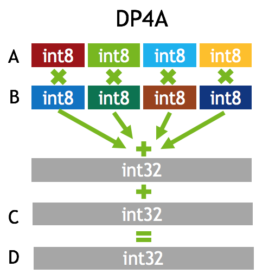

In [23]:
Image("images/dp4a-updated.png")

## Reduced Dynamic Range of INT8

While this new instruction provides faster computation, there is a significant challenge in representing weights and activations of deep neural networks in this reduced INT8 format. As *Table 1* shows, the dynamic range and granularity of representable values for INT8 is significantly limited compared to FP32 or FP16.

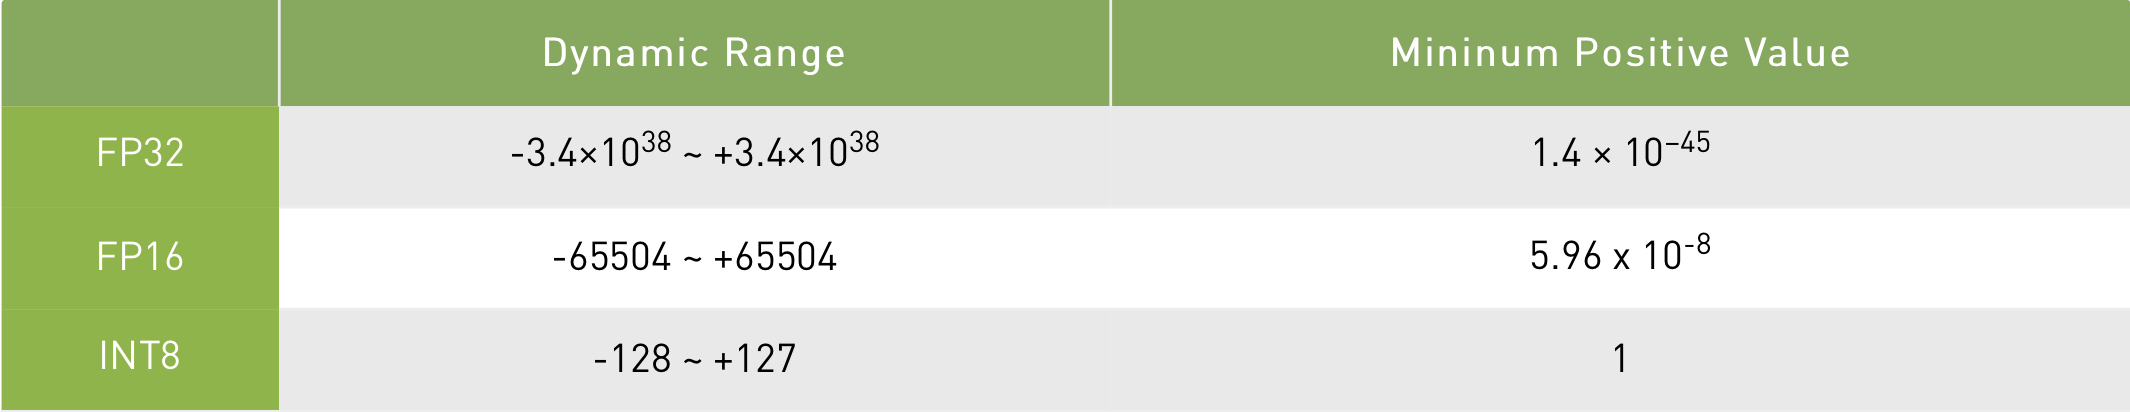

In [24]:
Image("images/table1.png")

## TF-TRT INT8 Quantization

You might be wondering how it is possible to take a model which operates in 32 bit floating point precision, where you can represent billions of different numbers, and reduce that to only 8 bit integers which can only represent 256 possible values.

The main reason is that, typically in deep learning, the values of weights and activations lie in very small ranges. So if we design our precious 8 bits to only represent this specific small range, we can usually maintain good accuracy while reducing the rounding error.

The main challenge is to find the correct dynamic range of the inputs. TF-TRT uses a calibration process that minimizes the information loss when approximating the FP32 network with a limited 8-bit integer representation. In the next notebook you will see how to perform this calibration process.

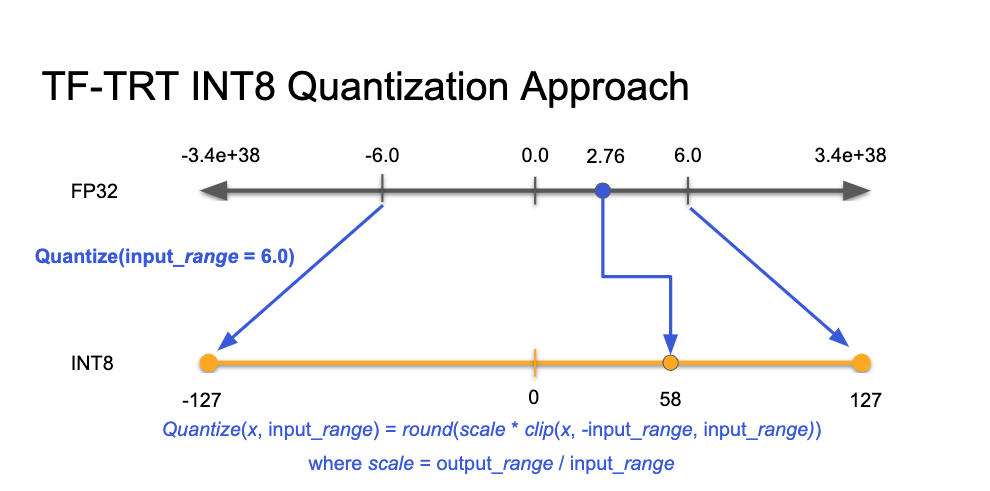

In [25]:
Image("images/int_8_approach.png")

## Calibration Dataset Considerations

When preparing the calibration dataset, you should capture the expected distribution of data in typical inference scenarios. You need to make sure that the calibration dataset covers all the expected scenarios, for example, clear weather, rainy day, night scenes, etc. When examining your own dataset, you should create a separate calibration dataset. The calibration dataset shouldn’t overlap with the training, validation or test datasets. 

For a much deeper technical dive on INT8 inference, you may watch the [8-Bit inference using TensorRT](http://on-demand.gputechconf.com/gtc/2017/video/s7310-szymon-migacz-8-bit-inference-with-tensorrt.mp4) presentation.

# Convert to TF-TRT INT8

In this notebook you will convert a TensorFlow saved model into a TF-TRT optimized graph using INT8 precision. You will use the optimized graph to make predictions and will benchmark its performance.

## Objectives

By the time you complete this notebook you wil be able to:

- Use TF-TRT to optimize a saved model with INT8 precision

## Converting to TF-TRT INT8

To perform INT8 optimization, we simply need to:

- Set `precision_mode` to `trt.TrtPrecisionMode.INT8`
- Pass a `calibration_input_fn` to `converter.convert`

### Calibration Input Function

`calibration_input_fn` should be a generator function that yields input data as a list or tuple.

You need to make sure that the calibration dataset covers all the expected scenarios, for example, clear weather, rainy day, night scenes, etc. When examining your own dataset, you should create a separate calibration dataset. The calibration dataset should not overlap with the training, validation, or test datasets.

For our simple example here, we will not take these extra steps and will simply pass in our `batched_input` as calibration data.

## Convert to TF-TRT INT8

In [0]:
convert_to_trt_graph_and_save(precision_mode='int8', input_saved_model_dir='resnet_v2_152_saved_model', calibration_data=batched_input)

## Benchmark TF-TRT INT8

Load the optimized TF model.

In [0]:
infer = load_tf_saved_model('resnet_v2_152_saved_model_TFTRT_INT8')

Perform inference with the optimized graph, and after a warmup, time and calculate throughput.

In [0]:
all_preds = predict_and_benchmark_throughput_from_saved(batched_input, infer, N_warmup_run=50, N_run=150)

Run this cell to view predictions, which you can use for comparison.

In [0]:
last_run_preds = all_preds[0]
display_prediction_info(last_run_preds, images)

## Next

In the next notebook you will optimize additional models, and experiment with the impact of changing the `minimum_segment_size` conversion parameter.

# Exercise: Benchmark Different Minimum Segment Sizes

In this notebook we will discuss the `minimum_segment_size` conversion parameter, and will ask you to experiment with the value, observing how it impacts throughput in optimized models.

Additionally, you will perform conversion for 2 additional models, VGG19 and InceptionV3.

## Objectives

By the end of this notebook you will be able to:

- Conduct experiments to understand the impact of the minimum segment size conversion parameter on a variety of models

In [0]:
from lab_helpers import (
    get_images, batch_input, load_tf_saved_model,
    predict_and_benchmark_throughput_from_saved, display_prediction_info
)

## Minimum Segment Size Conversion Parameter

The success of a TF-TRT optimization task is also dependent on the architecture of the model. The more supporting layers comprising the model, the greater number of TF-TRT layers generated and consequently, higher performance is achieved.

The `minimum_segment_size` conversion parameter determines the minimum number of nodes required for a subgraph to be replaced by an optimized TF-TRT op. While its default value of 3 tends to offer the best performance for most models, adjusting this value can have varying impact on different models.

For even more on the impacts of this parameter, see the [TF-TRT User Guide](https://docs.nvidia.com/deeplearning/frameworks/tf-trt-user-guide/#min-nodes).

## VGG19 and InceptionV3 Models

In this notebook we will utilize 2 additional models: **VGG19** and **InceptionV3**. Execute the following cells to load them, and save them to file, so that they are in the format TF-TRT expects. Feel free to continue reading while the models save.

In [0]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [0]:
vgg19_model = VGG19(weights='imagenet')
inception_v3_model = InceptionV3(weights='imagenet')

In [0]:
vgg19_model.save('vgg19_saved_model')
inception_v3_model.save('inception_v3_saved_model')

### Batch Input for Additional Models

Before we performance inference (and benchmark), we need to batch our input.

Our `batch_input` helper function performs model-specific image preprocessing. Therefore we create one set of batched images for each of the 2 additional models. If you're interested, check out `lab_helpers.py` for the source code.

In [0]:
number_of_images = 16
images = get_images(number_of_images)

In [0]:
vgg19_batched_input = batch_input(images, model="vgg19")

In [0]:
inception_v3_batched_input = batch_input(images, model="inception_v3")

## Benchmark Different Minimum Segment Sizes

As you can see, the default value for `minimum_segment_size` is `3`.

In [0]:
trt.DEFAULT_TRT_CONVERSION_PARAMS

For this exercise you are asked to optimize the  **vgg_19** and **inception_v3** models, varying `minimum_segment_size` to maximize throughput (on FP16 mode only).

### Allow for Different Minimum Segment Size Values

As you can see, `convert_to_trt_graph_and_save` now accepts a `minimum_segment_size` argument, which can be used to control the minimum segment size during conversion to a TF-TRT optimized model. Read the comments to see pertinent changes to our helper function.

In [0]:
def convert_to_trt_graph_and_save(
    precision_mode='float16',
    input_saved_model_dir='vgg19_saved_model',
    max_batch_size=16,
    # Allow for control of minimum_segment_size value
    minimum_segment_size=3
):
    precision_mode = trt.TrtPrecisionMode.FP16
    converted_save_suffix = '_TFTRT_FP16'
    
        
    if minimum_segment_size != 3:
        # Adjust filename for a given minimum segment size
        converted_save_suffix += '_MSS_{}'.format(str(minimum_segment_size))
        
    output_saved_model_dir = input_saved_model_dir + converted_save_suffix
    
    conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(
        precision_mode=precision_mode, 
        max_workspace_size_bytes=8000000000,
        max_batch_size=max_batch_size,
        # Pass in adjusted minimum segment size to conversion parameters
        minimum_segment_size=minimum_segment_size
    )

    converter = trt.TrtGraphConverterV2(
        input_saved_model_dir=input_saved_model_dir,
        conversion_params=conversion_params
    )

    print('Converting {} to TF-TRT graph precision mode {}...'.format(input_saved_model_dir, precision_mode))
    
    converter.convert()

    print('Saving converted model to {}...'.format(output_saved_model_dir))
    converter.save(output_saved_model_dir=output_saved_model_dir)
    print('Complete')

### Benchmarking Table

As you perform the following operations, use this table to track your results.

Throughput

      Model  |   Minimum Segment Size
             |      1             5      
--------------------------------------
             |
vgg_19       |     TODO          TODO
             |
             |
inception_v3 |     TODO          TODO
             |

### Benchmark Different Minimum Segment Sizes for VGG19

Run the following cells, adjusting `minimum_segment_size` so that you can observe the impact of its value when using VGG19.

In [0]:
model_name = 'vgg19'
minimum_segment_size = 1 # TODO: Optimize for minimum segment sizes of 1 and 5

In [0]:
input_saved_model_dir = '{}_saved_model'.format(model_name) # See above for where we saved the model

convert_to_trt_graph_and_save(precision_mode='float16',
                              minimum_segment_size=minimum_segment_size, # Here we control minimum segment size for the conversion
                              input_saved_model_dir=input_saved_model_dir)

In [0]:
infer = load_tf_saved_model('{}_saved_model_TFTRT_FP16_MSS_{}'.format(model_name, str(minimum_segment_size)))

In [0]:
# We use batched input, and process predictions, specifically for VGG19
# Record Throughput in the table above
all_preds = predict_and_benchmark_throughput_from_saved(vgg19_batched_input, infer, N_run=150, N_warmup_run=50, model='vgg19')

Optionally, display prediction info for this model.

In [0]:
last_run_preds = all_preds[0]
display_prediction_info(last_run_preds, images, model='vgg19')

### Benchmark Different Minimum Segment Sizes for InceptionV3

Run the following cells, adjusting `minimum_segment_size` so that you can observe the impact of its value when using InceptionV3.

In [0]:
model_name = 'inception_v3'
minimum_segment_size = 1 # TODO: Optimize for minimum segment sizes of 1 and 5

In [0]:
input_saved_model_dir = '{}_saved_model'.format(model_name) # See above for where we saved the model

convert_to_trt_graph_and_save(precision_mode='float16',
                              minimum_segment_size=minimum_segment_size, # Here we control minimum segment size for the conversion
                              input_saved_model_dir=input_saved_model_dir)

In [0]:
infer = load_tf_saved_model('{}_saved_model_TFTRT_FP16_MSS_{}'.format(model_name, str(minimum_segment_size)))

In [0]:
# We use batched input, and process predictions, specifically for InceptionV3
# Record Throughput in the table above
all_preds = predict_and_benchmark_throughput_from_saved(inception_v3_batched_input, infer, N_run=150, N_warmup_run=50, model='inception_v3')

Optionally, display prediction info for this model.

In [0]:
last_run_preds = all_preds[0]
display_prediction_info(last_run_preds, images, model='inception_v3')

<div align="center">
    <img width="1000px" src='images/table2.PNG' />
    <p style="text-align: center;color:gray">Figure 1: Accelerated model inference benchmarks </p>
</div>

## Jupyter Kernels

### Restarting Kernel at the End of Notebooks

The compute backend for Jupyter (as opposed to this web front-end you are viewing) is called the *kernel*. It may be the case while programming that you do something resulting in a kernel freeze or crash. You can interupt or restart the kernel at anytime using Jupyter's *Kernel* menu. Check it out now to familiarize yourself with it.

There are many small notebooks that you will be working through in this workshop, and our intent is for you to start with clean GPU memory and namespace for each kernel. With that in mind, we will ask you to restart the kernel at the end of every notebook, to clear the stage for the next.

Although you have not done any computing yet, execute the cell below (or use the *Kernel* menu) now to restart the kernel before proceeding to the next notebook.

In [0]:
import IPython
IPython.Application.instance().kernel.do_shutdown(True)